##### Cargue de librerias

In [1]:
from pycaret.clustering import *
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

import warnings
warnings.filterwarnings("ignore")

##### Conexion al DWH de Dispapeles y carga de bds adicionales

In [2]:
def df_clustering(consulta_SQL):
    ## Conexion al DWH
    cnxn = pyodbc.connect(
        driver='{SQL Server}',
        server='192.168.100.58',
        uid='bilectura',
        pwd='D1sp@p3l3s')
    cursor = cnxn.cursor()
    
    #Cargue de la data desde el ERP de Dispapeles y se guarda en df
    cursor.execute(consulta_SQL)
    rows = cursor.fetchall()
    
    df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

    return df

##### Funcion EDA

In [3]:
def histograma(bd):
    fig, ax = plt.subplots(1, 3, figsize= (15,5))
    sns.kdeplot(bd["Escala R"], ax= ax[0], color= "blue", fill= True)
    sns.kdeplot(bd["Escala F"], ax= ax[1], color= "red", fill= True)
    sns.kdeplot(bd["Escala M"], ax= ax[2], color= "yellow", fill= True)
    fig.suptitle("Distribuciones del modelo RFM")
    plt.show()

def scatter(bd):
    fig, ax = plt.subplots(1, 1, figsize= (8,5))
    sns.scatterplot(x= "Escala R", size= "Escala F", y= "Escala M", data= bd)
    fig.suptitle("Scatter del modelo RFM")
    plt.show()

def matrix(bd, col):
    corr_matrix = bd[col].corr()
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    plt.title("Matriz de correlación")
    plt.show()

def EDA(bd):
    bd = bd.reset_index()
    print(f"Esta base de datos tiene {len(bd)} registros,")
    print(f"hace parte del distrito {bd['Codigo distrito'][0]}")
    print(f"y el tipo de zona es {bd['Nombre tipo zona'][0]}")
    
    print(" ")
    print("Describe de la base de datos")
    describe = bd.describe().applymap("{:,.0f}".format)
    print(describe[["Escala R", "Escala F", "Escala M"]][1:])
    
    print(" ")
    
    # Variables auxiliares
    max = bd["Escala M"].max()
    min = bd["Escala M"].min()
    rango = max - min
    # mean = 
    # sd =
        
    print(f"El valor máx del campo Escala M es: {max:,.0f}")
    print(f"y el valor min es: {min:,.0f}")
    print(f"por lo tanto su rango es de: {rango:,.0f}")

    histograma(bd)
    scatter(bd)
    matrix(bd, ["Escala R", "Escala F", "Escala M"])

##### Funciones estandarizacion

In [4]:
# Crear una función para asignar etiquetas basadas en percentiles
def asignar_escala_R(valor, escalas_R= [21, 18, 12, 6, 0]):
    if valor >= escalas_R[0]:
        return 5
    elif valor >= escalas_R[1]:
        return 4
    elif valor >= escalas_R[2]:
        return 3
    elif valor >= escalas_R[3]:
        return 2
    else:
        return 1
    
def asignar_escala_F(valor, escalas_F= [21, 18, 12, 6, 0]):
    if valor >= escalas_F[0]:
        return 5
    elif valor >= escalas_F[1]:
        return 4
    elif valor >= escalas_F[2]:
        return 3
    elif valor >= escalas_F[3]:
        return 2
    else:
        return 1
    
def asignar_escala_M(valor):
    if valor <= escalas_M[1]:
        return 1
    elif valor <= escalas_M[2]:
        return 2
    elif valor <= escalas_M[3]:
        return 3
    elif valor <= escalas_M[4]:
        return 4
    else:
        return 5
    

##### Carga de la base de datos

In [5]:
# Consulta SQL para descargar la informacion a usar
codigo_SQL = "SELECT A.DSTCOD AS 'Codigo distrito', B.VNDZNA AS 'Codigo zona actual', CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC) AS 'Nit cliente-sucursal', A.VTAANO AS 'Ano', A.VTAMES AS 'Mes', (((2021 - MAX(A.VTAANO)) * 12 ) + (0 - MAX(A.VTAMES))) * -1 AS 'Recency', SUM(A.VTAVLRVTA) AS 'Monetary', COUNT( DISTINCT A.VTAMES) AS 'Frequency' FROM V_VTA_VTAHEC A LEFT JOIN	DIM_CLIENTES B ON A.PRMCOD = B.PRMCOD AND A.DSTCOD = B.DSTCOD AND A.VTANIT = B.CLTNIT AND A.VTASUC = B.CLTSUC WHERE A.PRMCOD = 1 AND A.DSTCOD NOT IN (30,35) AND A.VTAZNA < 96 AND A.VTAFCH BETWEEN '2021-01-01' AND '2022-12-31' GROUP BY A.DSTCOD, B.VNDZNA, CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC), A.VTAANO, A.VTAMES HAVING SUM(A.VTAVLRVTA) > 0"

# Consulta adicional para establecer el tipo de zona
maestra_zonas = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/Maestra_zonas.csv', delimiter= ";")

In [6]:
df = df_clustering(codigo_SQL)

##### Tranformaciones

In [7]:
# Conversion de tipo de la columna Monetary
df["Monetary"] = df["Monetary"].astype(int)

# Join con la maestra de zonas para determinar el tipo de zona
df_2 = pd.merge(df, maestra_zonas, on= ["Codigo distrito", "Codigo zona actual"])

# Filtro de la informacion para excluir zonas no relevantes
list_filter = ['Artes graficas', 'TIG', 'V Horeca', 'Institucional', 'V SyE',
                'V Industria', 'Mayorista']
df = df_2[df_2["Nombre tipo zona"].isin(list_filter)]

# DF final agregada por tipo de zona
df_3 = df.groupby(["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal"]).agg({"Recency": np.max,
                                                                            "Monetary": np.sum,
                                                                            "Frequency": np.sum
                                                                            })
df_3 = df_3.reset_index(col_level= 1)

In [8]:
# Se añade una key de Distrito-Nombretipozona para hacer mas facil la identificacion cuando se usa todo el pais
df_3['Distrito-Nombretipozona'] = df_3['Codigo distrito'].astype(str) + '-' + df_3['Nombre tipo zona']

# Aplicar la función para asignar etiquetas a una nueva columna "Etiqueta"
escalas_M = np.percentile(df_3["Monetary"].values, [0, 20, 50, 80, 95, 100])

df_est = df_3
df_est["Escala R"] = df_3["Recency"].apply(asignar_escala_R, escalas_R= [25, 21, 15, 8, 0])
df_est["Escala F"] = df_3["Frequency"].apply(asignar_escala_F, escalas_F= [25, 21, 15, 8, 0])
df_est["Escala M"] = df_3["Monetary"].apply(asignar_escala_M)
df_est = df_est.drop(["Recency", "Frequency", "Monetary"], axis=1)
df_est

,Codigo distrito,Nombre tipo zona,Nit cliente-sucursal,Distrito-Nombretipozona,Escala R,Escala F,Escala M
0,10,Artes graficas,1010197660-1,10-Artes graficas,2,1,2
1,10,Artes graficas,1010208977-1,10-Artes graficas,1,1,2
2,10,Artes graficas,1012348815-1,10-Artes graficas,1,1,1
3,10,Artes graficas,1013637504-1,10-Artes graficas,1,1,1
4,10,Artes graficas,1013642113-1,10-Artes graficas,4,1,3
...,...,...,...,...,...,...,...
14386,90,Mayorista,93300278-1,90-Mayorista,3,1,2
14387,90,Mayorista,93370623-1,90-Mayorista,4,4,3
14388,90,Mayorista,93386132-1,90-Mayorista,4,3,5
14389,90,Mayorista,93414007-1,90-Mayorista,4,3,3


##### Creacion, ajuste y descarga de los modelos de clustering por cada distrito-tipo de zona

In [9]:
list_dtos = df_est["Distrito-Nombretipozona"].unique()
numeric_features = ["Escala R", "Escala F", "Escala M"]
ignore_columns = ["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal", "Distrito-Nombretipozona"]

#### EDA

In [10]:
df_EDA = df_est[df_est["Distrito-Nombretipozona"] == '10-Artes graficas']

Esta base de datos tiene 523 registros,
hace parte del distrito 10
y el tipo de zona es Artes graficas
 
Describe de la base de datos
     Escala R Escala F Escala M
mean        3        2        3
std         1        1        1
min         1        1        1
25%         3        1        2
50%         4        1        3
75%         4        3        4
max         4        4        5
 
El valor máx del campo Escala M es: 5
y el valor min es: 1
por lo tanto su rango es de: 4


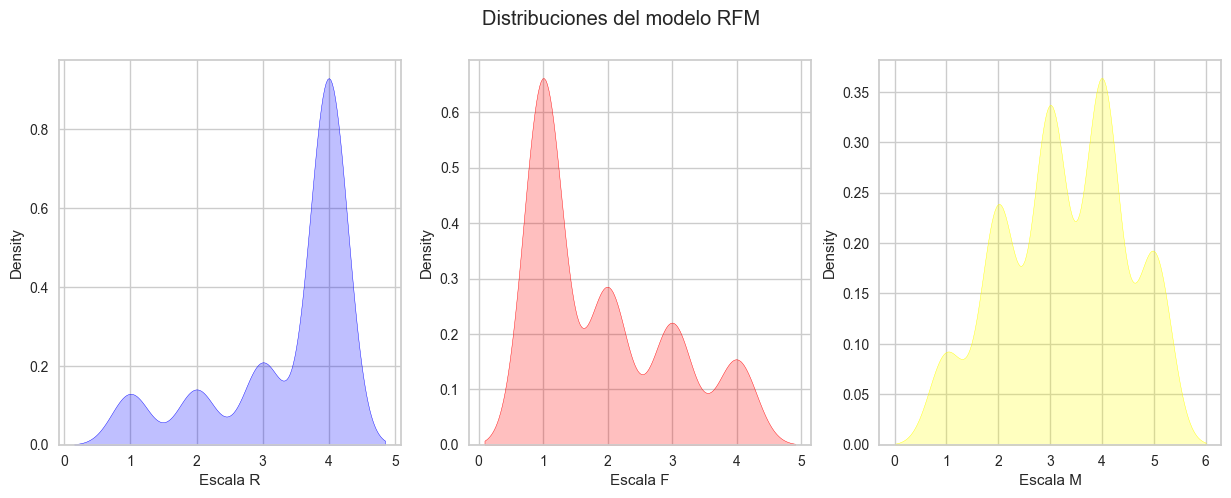

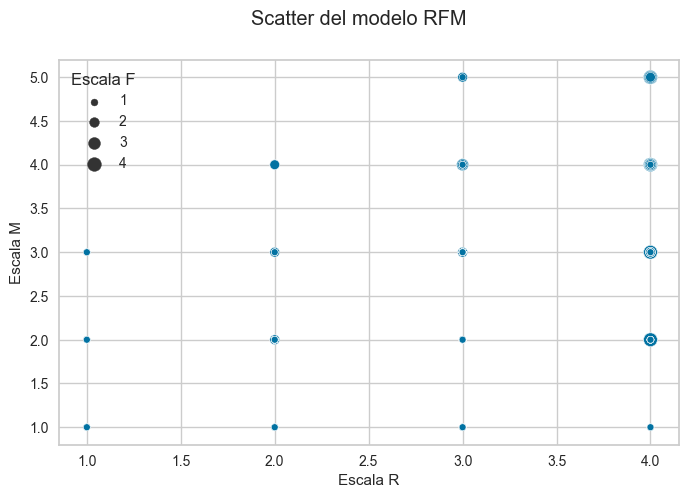

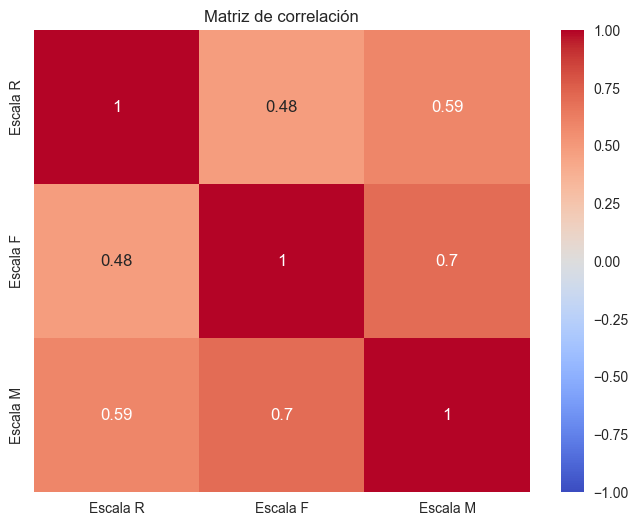

In [11]:
EDA(df_EDA)

In [12]:
# list_dtos = ['10-Artes graficas', '10-Institucional', '10-Mayorista', '10-TIG', '10-V Horeca', '10-V Industria', '10-V SyE']
# list_dtos = ['10-Artes graficas']

##### Un modelo

In [24]:
# Variables iniciales
metrics = []
bd_predicted_all = pd.DataFrame()

# Fecha para guardar resultados
fecha = '12-04-23'

# Ciclo para realizar el modelo de clustering por cada tipo de zona del pais
for n, dto in enumerate(list_dtos):
    print(f"Procesando modelo {n+1} de {len(list_dtos)}. {(n+1) / (len(list_dtos)):.1%}")
    
    #BD filtrada
    df_dto = df_est[df_est["Distrito-Nombretipozona"] == dto]

    #Setup del modelo 
    s = setup(
                df_dto,
                verbose= False,
                preprocess= False,
                profile= False,
                ignore_features= ignore_columns,
                numeric_features= numeric_features
                )
    
    #Creacion y prediccion de modelo
    model_kmeans = create_model(
                                'kmeans',
                                num_clusters= 5,
                                verbose= False,
                                )
    pull()
    df_pred_km = predict_model(
                                model_kmeans,
                                data = df_dto
                                )
    
    # Reasignacion de los nombres de los clusters
    trans = df_pred_km.groupby(
                                ["Cluster"]).agg({
                                                "Escala R": np.mean, "Escala F": np.mean, "Escala M": np.mean,
                                            }).reset_index()
    trans["avg"] = (trans["Escala R"] + trans["Escala F"] + trans["Escala M"]) / 3
    trans = trans.sort_values(by= ["avg"], ascending= False)
    trans["Letra cluster"] = ["A", "B", "C", "D", "E"]
    trans = trans[["Cluster", "Letra cluster"]]
    
    df_pred_km = pd.merge(df_pred_km, trans, on= ["Cluster"])
    df_pred_km = df_pred_km.drop_duplicates(subset=["Escala R", "Escala F", "Escala M"])
    
    # Descarga del modelo
    bd_predicted = pd.merge(df_dto, df_pred_km, on= ["Escala R", "Escala F", "Escala M"])

    bd_predicted_all = pd.concat([bd_predicted_all, bd_predicted], ignore_index=  True)

    #Append a la variable incial de metricas
    metrics.append({
                    "Distrito-zona": dto,
                    "Silhouette": pull().Silhouette[0],
                    "Calinski-Harabasz": pull()["Calinski-Harabasz"][0],
                    "Davies-Bouldin": pull()["Davies-Bouldin"][0]
                    })
    # save_model(model_kmeans, f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Modelos {fecha}/Modelo {dto} {fecha}")

# Transformacion de la variable de metricas
metrics = pd.DataFrame(metrics)
metrics["Tipo zona"] = metrics["Distrito-zona"].str[3:]

print("Proceso completo 100%")

Procesando modelo 1 de 67. 1.5%
Procesando modelo 2 de 67. 3.0%
Procesando modelo 3 de 67. 4.5%
Procesando modelo 4 de 67. 6.0%
Procesando modelo 5 de 67. 7.5%
Procesando modelo 6 de 67. 9.0%
Procesando modelo 7 de 67. 10.4%
Procesando modelo 8 de 67. 11.9%
Procesando modelo 9 de 67. 13.4%
Procesando modelo 10 de 67. 14.9%
Procesando modelo 11 de 67. 16.4%
Procesando modelo 12 de 67. 17.9%
Procesando modelo 13 de 67. 19.4%
Procesando modelo 14 de 67. 20.9%
Procesando modelo 15 de 67. 22.4%
Procesando modelo 16 de 67. 23.9%
Procesando modelo 17 de 67. 25.4%
Procesando modelo 18 de 67. 26.9%
Procesando modelo 19 de 67. 28.4%
Procesando modelo 20 de 67. 29.9%
Procesando modelo 21 de 67. 31.3%
Procesando modelo 22 de 67. 32.8%
Procesando modelo 23 de 67. 34.3%
Procesando modelo 24 de 67. 35.8%
Procesando modelo 25 de 67. 37.3%
Procesando modelo 26 de 67. 38.8%
Procesando modelo 27 de 67. 40.3%
Procesando modelo 28 de 67. 41.8%
Procesando modelo 29 de 67. 43.3%
Procesando modelo 30 de 67. 4

In [25]:
# Descarga de bd predicha y metricas calculadas
bd_predicted_all.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering {fecha}.csv",
                        encoding= 'utf-8', index= False, decimal= ",", sep= ";")
metrics.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Metricas {fecha}.csv",
                        encoding= 'utf-8', index= False, decimal= ",",  sep= ";")

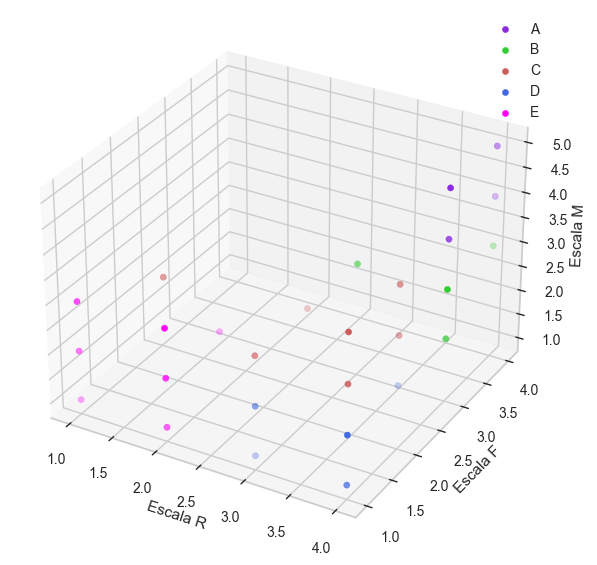

In [26]:
col =  ["blueviolet", "limegreen", "indianred", "royalblue", "magenta", "blueviolet"]
leg = ["A", "B", "C", "D", "E"]
cluster = list(np.unique(df_pred_km["Letra cluster"]))

fig = plt.figure(figsize=(7,10))
ax = fig.gca(projection='3d')

for c in range(5):
    df_plot = df_pred_km[df_pred_km['Letra cluster'] == cluster[c]]
    ax.scatter(df_plot['Escala R'],df_plot['Escala F'], df_plot['Escala M'], c= col[c])
    
ax.legend(leg)
ax.set_xlabel('Escala R')
ax.set_ylabel('Escala F')
ax.set_zlabel('Escala M')
plt.show()

In [16]:
plot_model(model_kmeans, plot = 'cluster')

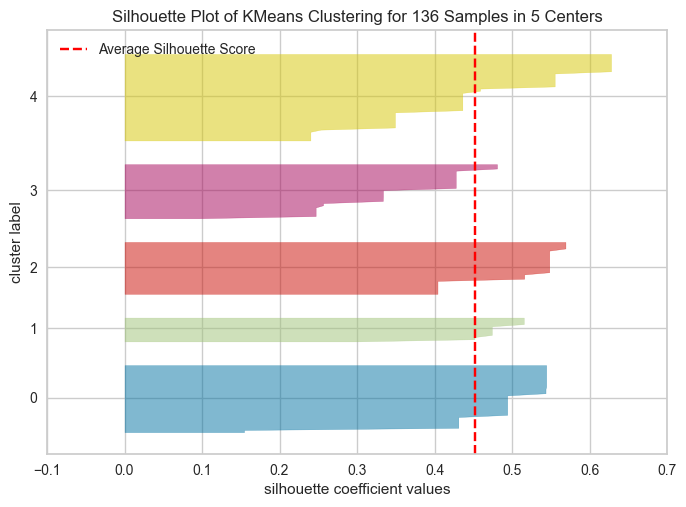

In [17]:
plot_model(model_kmeans, plot = 'silhouette')

In [18]:
plot_model(model_kmeans, plot = 'distribution')